# Segmentation

## Import

In [1]:
import os
import math
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

## Dataset

In [2]:
def build_augmentation(is_train=True):
    if is_train:
        return Compose([
            HorizontalFlip(p=0.5),
            RandomSizedCrop(
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(
                width=224,
                height=224
            )
        ])
    return Compose([
        Resize(
            width=224,
            height=224
        )
    ])

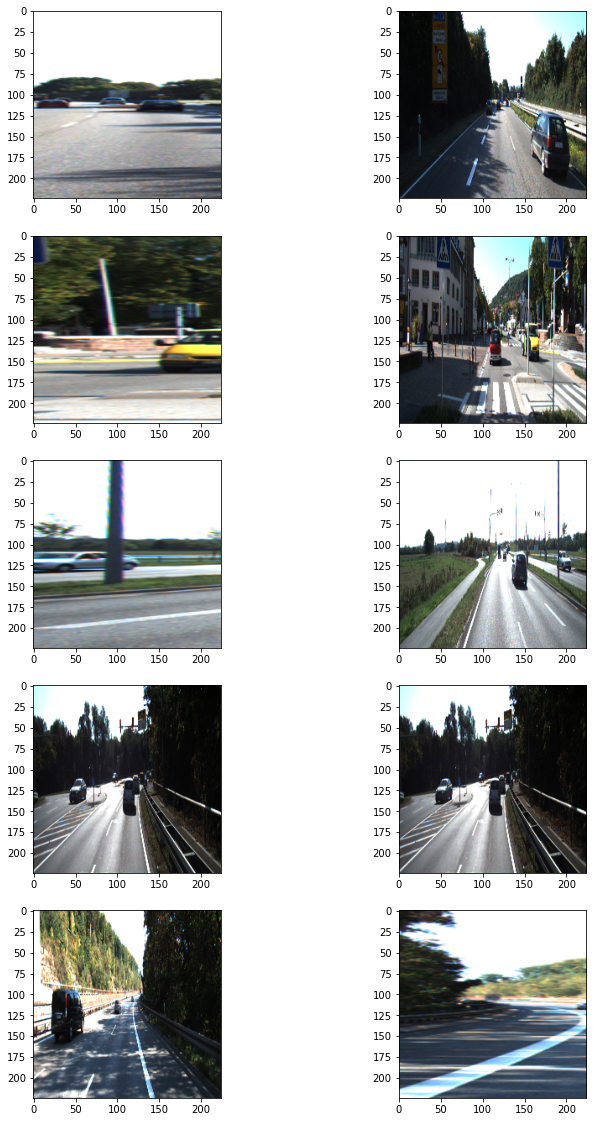

In [3]:
dir_path = './data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image": image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])

plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                 dir_path,
                 batch_size=4,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):

        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    augmentation=test_preproc,
    is_train=False
)

## U-Net

In [6]:
def build_UNet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv1)
    batch1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv2)
    batch2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    conv3 = Conv2D(256, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv3)
    batch3 = BatchNormalization()(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    conv4 = Conv2D(512, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv4)
    batch4 = BatchNormalization()(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    # Expansive path
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch5)) 
    merge6 = concatenate([conv4,up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    crop_conv3 = tf.image.resize(conv3, (up7.shape[1], up7.shape[2]))
    merge7 = concatenate([crop_conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    crop_conv2 = tf.image.resize(conv2, (up8.shape[1], up8.shape[2]))
    merge8 = concatenate([crop_conv2,up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    crop_conv1 = tf.image.resize(conv1, (up9.shape[1], up9.shape[2]))
    merge9 = concatenate([crop_conv1,up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [7]:
UNet = build_UNet()
UNet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 110, 110, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

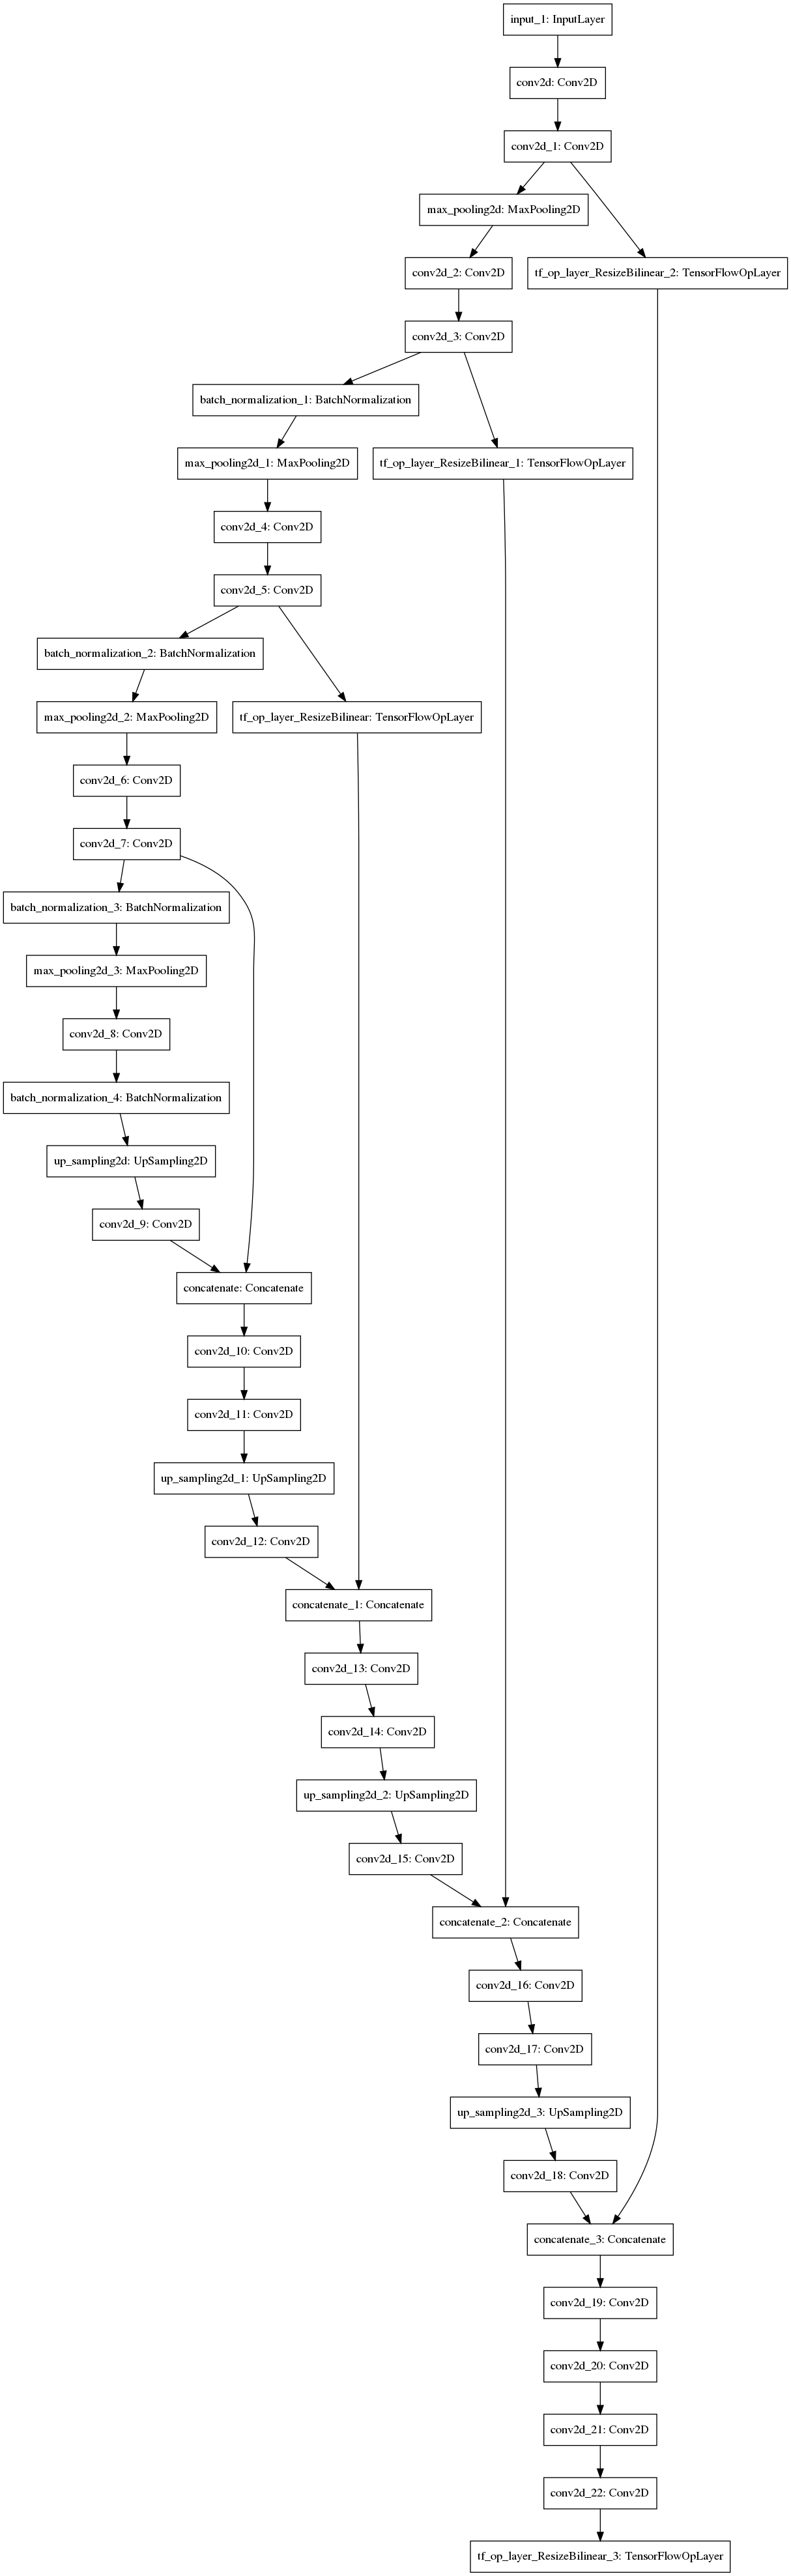

In [8]:
tf.keras.utils.plot_model(UNet, to_file='./model/U-Net.png')

In [9]:
UNet.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')

In [10]:
UNet.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
43/43 [==============================] - 5s 106ms/step - loss: 0.2012 - val_loss: 0.1734
Epoch 2/100
43/43 [==============================] - 4s 102ms/step - loss: 0.1557 - val_loss: 0.1532
Epoch 3/100
43/43 [==============================] - 4s 104ms/step - loss: 0.1053 - val_loss: 0.1300
Epoch 4/100
43/43 [==============================] - 4s 100ms/step - loss: 0.0843 - val_loss: 0.1245
Epoch 5/100
43/43 [==============================] - 4s 99ms/step - loss: 0.1163 - val_loss: 0.1137
Epoch 6/100
43/43 [==============================] - 5s 113ms/step - loss: 0.0838 - val_loss: 0.1264
Epoch 7/100
43/43 [==============================] - 5s 116ms/step - loss: 0.0713 - val_loss: 0.0926
Epoch 8/100
43/43 [==============================] - 5s 116ms/step - loss: 0.1012 - val_loss: 0.0931
Epoch 9/100
43/43 [==============================] - 5s 114ms/step - loss: 0.0689 - val_loss: 0.0891
Epoch 10/100
43/

43/43 [==============================] - 5s 106ms/step - loss: 0.0478 - val_loss: 0.0552
Epoch 77/100
43/43 [==============================] - 5s 111ms/step - loss: 0.0509 - val_loss: 0.0586
Epoch 78/100
43/43 [==============================] - 5s 107ms/step - loss: 0.0410 - val_loss: 0.0450
Epoch 79/100
43/43 [==============================] - 5s 110ms/step - loss: 0.0341 - val_loss: 0.0450
Epoch 80/100
43/43 [==============================] - 5s 107ms/step - loss: 0.0380 - val_loss: 0.0506
Epoch 81/100
43/43 [==============================] - 5s 108ms/step - loss: 0.0511 - val_loss: 0.0885
Epoch 82/100
43/43 [==============================] - 5s 111ms/step - loss: 0.0414 - val_loss: 0.0828
Epoch 83/100
43/43 [==============================] - 5s 107ms/step - loss: 0.0660 - val_loss: 0.3771
Epoch 84/100
43/43 [==============================] - 5s 112ms/step - loss: 0.0584 - val_loss: 0.0501
Epoch 85/100
43/43 [==============================] - 5s 106ms/step - loss: 0.0389 - val_loss: 

In [12]:
UNet_model_path = './model/seg_model_unet.h5'
UNet.save(UNet_model_path)

## U-Net++

In [ ]:
def build_UNet_plus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv1)
    batch1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv2)
    batch2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    conv3 = Conv2D(256, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv3)
    batch3 = BatchNormalization()(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    conv4 = Conv2D(512, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv4)
    batch4 = BatchNormalization()(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    # Expansive path
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch5)) 
    merge6 = concatenate([conv4,up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    crop_conv3 = tf.image.resize(conv3, (up7.shape[1], up7.shape[2]))
    merge7 = concatenate([crop_conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    crop_conv2 = tf.image.resize(conv2, (up8.shape[1], up8.shape[2]))
    merge8 = concatenate([crop_conv2,up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    crop_conv1 = tf.image.resize(conv1, (up9.shape[1], up9.shape[2]))
    merge9 = concatenate([crop_conv1,up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [ ]:
UNet_plus = build_UNet_plus()
UNet_plus.summary()

In [ ]:
tf.keras.utils.plot_model(UNet_plus, to_file='./model/U-Net++.png')

In [ ]:
UNet_plus.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')

In [ ]:
UNet_plus.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

In [ ]:
UNet_plus_model_path = './model/seg_model_unet_plus.h5'
UNet.save(UNet_plus_model_path)

## U-Net vs U-Net++

In [13]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [21]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    
    plt.figure(figsize=(12, 20))
    plt.imshow(output)

    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

### U-Net

IoU : 0.795316


0.7953157463955172

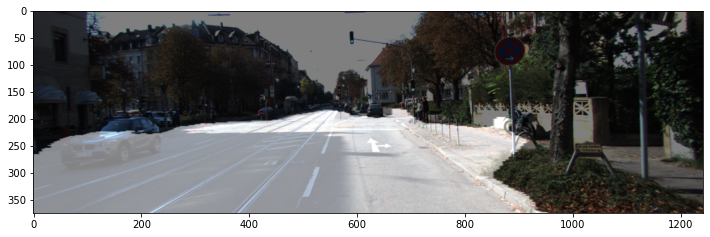

In [22]:
i = 1
output, prediction, target = get_output(
     UNet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

### U-Net++

In [ ]:
i = 1
output, prediction, target = get_output(
     UNet_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## Report

...